In [20]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis

In [3]:
df = pd.read_csv("vw_reviews.csv")

In [24]:
def get_wordnet_pos(pos_tag):
        if pos_tag.startswith('J'):
            return wordnet.ADJ
        elif pos_tag.startswith('V'):
            return wordnet.VERB
        elif pos_tag.startswith('N'):
            return wordnet.NOUN
        elif pos_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
def text_clean (text):
        # lower text
        text = text.lower()
        # tokenize text and remove puncutation
        text = [word.strip(string.punctuation) for word in text.split(" ")]
        # remove words that contain numbers
        text = [word for word in text if not any(c.isdigit() for c in word)]
        # remove stop words
        stop = stopwords.words('english')
        text = [x for x in text if x not in stop]
        # remove empty tokens
        text = [t for t in text if len(t) > 0]
        # pos tag text
        pos_tags = pos_tag(text)
        # lemmatize text
        text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
        # remove words with only one letter
        text = [t for t in text if len(t) > 1]
        # join all
        text = " ".join(text)
        return(text)
    
def review_clean (review):
        review["pros_clean"] = review["pros"].apply(lambda x: text_clean(x))
        review["cons_clean"] = review["cons"].apply(lambda x: text_clean(x))
        return (review)
    
def vectorization (data):
        vectorizer = TfidfVectorizer()
        cleaned = vectorizer.fit_transform(data["text_clean"])
        return (cleaned)
    
def get_topics(components, feature_names, n=50):
        for idx, topic in enumerate(components):
            print("\nTopic %d: " % (idx+1), 
                  [(feature_names[i], topic[i].round(2)) 
                   for i in topic.argsort()[:-n - 1:-1]])
    
def display_topics(model, feature_names, no_top_words):
        topic_dict = {}
        for topic_idx, topic in enumerate(model.components_):
            topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
            topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        return pd.DataFrame(topic_dict)
    
def topic_analysis (data, number_of_topics = 10):
        
        vectorizer = CountVectorizer()
        clean = vectorizer.fit_transform(data)
        feature_names = vectorizer.get_feature_names()
        lda = LatentDirichletAllocation(n_components=number_of_topics,random_state=27)
        lda.fit(clean)
        
        topic_df = display_topics (lda, feature_names, 30)
        return (topic_df, lda, clean, feature_names)
    
def topic_visualization (data, number_of_topics=10):
        
        topic_df, lda, clean, feature_names = topic_analysis(data = data, 
                                                                  number_of_topics = number_of_topics)
        
        topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, None]
        doc_lengths = clean.sum(axis=1).getA1()
        term_frequency = clean.sum(axis=0).getA1()
        lda_doc_topic_dists = lda.transform(clean)
        doc_topic_dists = lda_doc_topic_dists / lda_doc_topic_dists.sum(axis=1)[:, None]
        vocab = feature_names
        
        lda_pyldavis = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
        #pyLDAvis.save_html(lda_pyldavis, 'lda.html')
        return(lda_pyldavis)#, pyLDAvis.display(lda_pyldavis))

In [21]:
df_clean = review_clean(df)

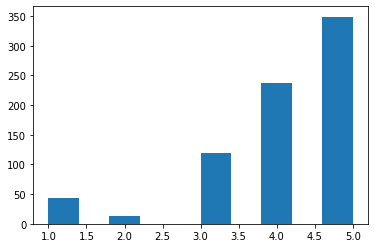

In [38]:
import matplotlib.pyplot as plt
plt.hist(df_clean['rating'])
plt.show()

In [25]:
lda_pros = topic_visualization(df_clean['pros_clean'])

c:\users\king\pycharmprojects\glassdoor-review-scraper\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\king\pycharmprojects\glassdoor-review-scraper\venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [29]:
pyLDAvis.save_html(lda_pros, 'lda_pros_topics.html')
pyLDAvis.display(lda_pros)

In [26]:
lda_cons =  topic_visualization(df_clean['cons_clean'])

In [30]:
pyLDAvis.save_html(lda_cons, 'lda_cons_topics.html')
pyLDAvis.display(lda_cons)

In [79]:
df_clean['date'] = df_clean["author_info"].str[:12]

In [87]:
df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean['date_str'] = df_clean['date'].astype(str)
df_clean['date_str_month'] = df_clean['date_str'].str[:7]
df_clean['date_str_year'] = df_clean['date_str'].str[:4]
df_clean['date_str_year'] = df_clean['date_str_year'].astype(int)

In [59]:
import plotly.express as px
fig = px.scatter(x=df_clean['date'], y=df_clean['rating'], color=df_clean['rating'])
fig.show()

In [89]:
df_clean['rating']

0      1.0
1      1.0
2      1.0
3      5.0
4      3.0
      ... 
756    4.0
757    3.0
758    3.0
759    5.0
760    3.0
Name: rating, Length: 761, dtype: float64

In [110]:
df_gb_2 = df_clean.groupby(df_clean['date_str_month']).mean()

In [119]:
df_gb['rating_sum'].astype(int)

date_str_year
2012      10
2013      18
2014       6
2015      36
2016      76
2017     107
2018     143
2019      83
2020     342
2021    1729
2022     569
Name: rating_sum, dtype: int32

In [105]:
df_gb['rating_sum'] = df_clean.groupby(df_clean['date_str_year']).sum()['rating']

In [122]:
fig = px.line(df_gb, x=df_gb.index, y='rating',
              title="Average Rating Through Time",
              labels={
                     "rating": "Glassdoor Employee Rating",
                     "date_str_year": "Year"},)
fig.show()

In [90]:
fig  = px.area(df_clean, x = 'date_str_year', color='rating')
fig.show()